In [1]:
using PyPlot, LinearAlgebra, Random, Distributions, ForwardDiff
using PyPlot: matplotlib
Random.seed!(2)
rc("axes.spines", top=false, right=false)

In [2]:
function HMC(log_p_tilde, μ₀; maxiter::Int=100000, L::Int=100, ϵ::Float64=1e-1)
    # leapfrog
    function leapfrog(grad, p_in, μ_in, L, ϵ)
        μ = μ_in
        p = p_in + 0.5 * ϵ * grad(μ)
        for l in 1:L-1
            μ += ϵ * p
            p += ϵ * grad(μ)
        end
        μ += ϵ * p
        p += ϵ * grad(μ)
        return p, μ
    end    
    
    grad(μ)= ForwardDiff.gradient(log_p_tilde, μ)
    D = length(μ₀)
    μ_samples = Array{typeof(μ₀[1]), 2}(undef, D, maxiter)
    
    μ_samples[:, 1] = μ₀
    num_accepted = 1
    
    for i in 2:maxiter
        p_in = randn(size(μ₀))
        p_out, μ_out = leapfrog(grad, p_in, μ_samples[:, i-1], L, ϵ)
        
        μ_in = μ_samples[:, i-1]
        log_out = log_p_tilde(μ_out) + logpdf(MvNormal(zeros(D), I), vec(p_out))
        log_in = log_p_tilde(μ_in) + logpdf(MvNormal(zeros(D), I), vec(p_in))
        log_r = log_out - log_in
        
        is_accepted = min(1, exp(log_r)) > rand()
        new_sample = is_accepted ? μ_out : μ_in
        
        μ_samples[:, i] = new_sample
        num_accepted += is_accepted
    end
    return μ_samples, num_accepted
end

HMC (generic function with 1 method)

In [3]:
function inference_wrapper_HMC(log_joint, params, w_init; maxiter::Int=100000, L::Int=100, ϵ::Float64=1e-1)
    ulp(w) = log_joint(w, params...)
    return HMC(ulp, w_init, maxiter=maxiter, L=L, ϵ=ϵ)
end

inference_wrapper_HMC (generic function with 1 method)

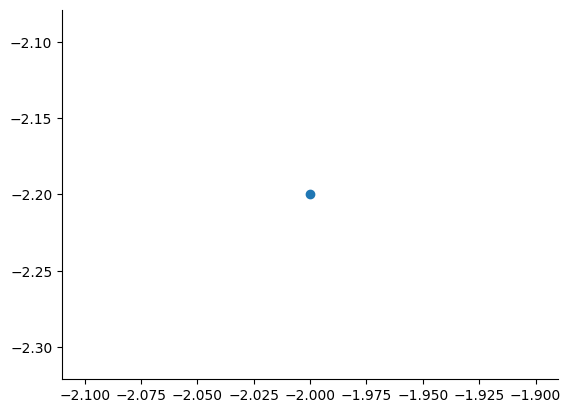

PyObject <matplotlib.collections.PathCollection object at 0x00000000011493A0>

In [16]:
X_obs = [-2]#, 1, 5]
Y_obs = [-2.2]#, -1.0, 1.5]

scatter(X_obs, Y_obs)

In [17]:
function log_joint(w, X, Y, σ, μ₁, σ₁, μ₂, σ₂)
    tmp = sum(logpdf.(Normal.(w[1]*X .+ w[2], σ), Y)) 
    tmp += logpdf(Normal(μ₁, σ₁), w[1])
    tmp += logpdf(Normal(μ₂, σ₂), w[2])
    return tmp
end

log_joint (generic function with 1 method)

In [18]:
σ, μ₁, μ₂, σ₁, σ₂ = 1.0, 0.0, 0.0, 10.0, 10.0

(1.0, 0.0, 0.0, 10.0, 10.0)

In [19]:
params = (X_obs, Y_obs, σ, μ₁, σ₁, μ₂, σ₂)

([-2], [-2.2], 1.0, 0.0, 10.0, 0.0, 10.0)

In [20]:
ulp(w) = log_joint(w, params...)

ulp (generic function with 1 method)

In [21]:
w_init = randn(2)

2-element Vector{Float64}:
 -0.5736035042439643
  0.38166997009367987

In [22]:
ulp(w_init)

-14.316621011030826

In [23]:
max_iter = 300

param_posterior, num_accepted = inference_wrapper_HMC(log_joint, params, w_init, maxiter=max_iter, L=10, ϵ=1e-1)

([-0.5736035042439643 1.5674411605372185 … 5.28611203353117 5.816150328326354; 0.38166997009367987 -1.9946082384587944 … 9.988255970282333 8.47046040254035], 287)

In [24]:
size(param_posterior)

(2, 300)

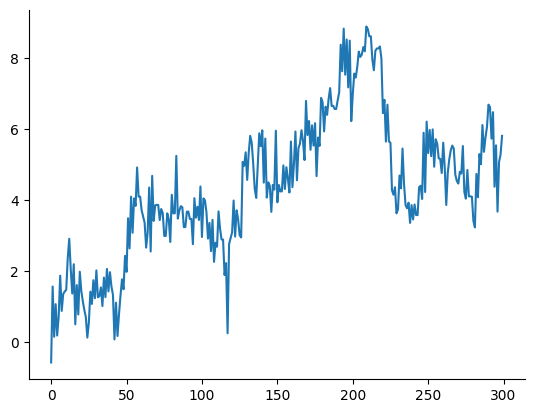

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000022F43D0>

In [25]:
plot(param_posterior[1, :])

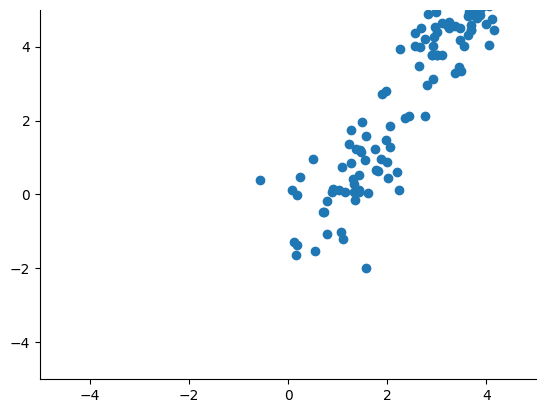

(-5.0, 5.0)

In [26]:
scatter(param_posterior[1, :], param_posterior[2, :])
xlim(-5,5)
ylim(-5,5)